In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from shapely import geometry
from tqdm import tqdm
import random
import scipy 

In [2]:
n = 8

pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))
rnd_coef = [0.1, 0.1, 0.1]
min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])

In [3]:

def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]



In [4]:


def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area

def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])

def torch_func(patterns):
    patterns = patterns.detach().cpu().numpy()
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s

def func(patterns):
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s


In [ ]:

def get_neighbors(solution):
    neighbors = []
    n = len(solution)
    for _ in range(10): 
        neighbor = list(solution)
        idx = random.randint(0, n - 1)
        old_coord = neighbor[idx]
        new_coord = (
            max(min_bound[0], min(old_coord[0] + random.uniform(-rnd_coef[0], rnd_coef[0]), max_bound[0])),
            max(min_bound[1], min(old_coord[1] + random.uniform(-rnd_coef[1], rnd_coef[1]), max_bound[1])),
            max(min_bound[2], min(old_coord[2] + random.uniform(-rnd_coef[2], rnd_coef[2]), max_bound[2])),
        )
        neighbor[idx] = new_coord
        neighbors.append(tuple(neighbor))
    return neighbors

def tabu_search(initial_solution, max_iterations, tabu_list_size):
    current_solution = initial_solution
    best_solution = initial_solution
    tabu_list = []

    for _ in tqdm(range(max_iterations)):
        neighbors = get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                fitness = func(neighbor)
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness

        if best_neighbor is None:
            break

        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)

        if func(current_solution) < func(best_solution):
            best_solution = current_solution

    return best_solution

# Инициализация: n наборов координат
n = 8
initial_solution = []
for _ in range(n):
    initial_solution.append((
        random.uniform(min_bound[0], max_bound[0]),
        random.uniform(min_bound[1], max_bound[1]),
        random.uniform(min_bound[2], max_bound[2])
    ))
initial_solution = tuple(initial_solution)  # чтоб была хешируемой для табу-листа

max_iterations = 1000
tabu_list_size = 10  

best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size)

print("Best solution:", best_solution)
print("Best fitness:", func(best_solution))


100%|██████████| 1000/1000 [00:19<00:00, 52.26it/s]

Best solution: ((np.float64(1.4992091818879147), np.float64(1.005958659663286), np.float64(6.283185307179586)), (np.float64(0.45793419423663145), np.float64(0.5012898676058685), np.float64(6.239793300215772)), (np.float64(0.9999227494622701), np.float64(1.518273195435352), np.float64(1.6082601575019286)), (np.float64(0.5129878409684366), np.float64(1.442832801695122), np.float64(3.0720477780211177)), (np.int64(0), np.float64(0.46622669651579285), np.float64(4.749738897364152)), (np.float64(1.0079541513290973), np.float64(1.0247810382230385), np.float64(0.01307253681232777)), (np.float64(0.9914269771642528), np.float64(0.45049860288345517), np.float64(4.78716996032777)), (np.float64(0.9343385923975172), np.float64(0.950648210393327), np.float64(4.805513589130392)))
Best fitness: 0.11627371386136


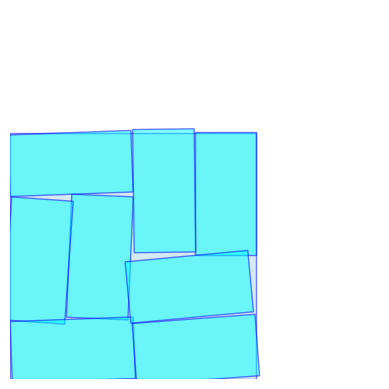

In [6]:
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()

In [ ]:


def objective(x):
    patterns = [x[i:i+3] for i in range(0, len(x), 3)]
    return func(patterns)

x0 = np.array([coord for pattern in best_solution for coord in pattern])

bounds = [(min_bound[i % 3], max_bound[i % 3]) for i in range(len(x0))]
result = scipy.optimize.minimize(objective, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 100})

improved_solution = [tuple(result.x[i:i+3]) for i in range(0, len(result.x), 3)]
improved_solution = tuple(improved_solution)

best_solution_after_ts = best_solution  

print("Improved solution:", improved_solution)
print("Improved fitness:", func(improved_solution))


Improved solution: ((np.float64(1.5000003339722625), np.float64(1.0000020099236508), np.float64(6.283185307179586)), (np.float64(0.49999942970114714), np.float64(0.5000028923475403), np.float64(6.283184721575401)), (np.float64(1.000002678677936), np.float64(1.50000743229813), np.float64(1.5708076811525082)), (np.float64(0.500002470217519), np.float64(1.4999976664562664), np.float64(3.1415833517242207)), (np.float64(0.0), np.float64(0.49999672616160956), np.float64(4.712398432307906)), (np.float64(0.9999988156985269), np.float64(1.0000174310361585), np.float64(0.0)), (np.float64(1.0002413086473512), np.float64(0.5004140687196611), np.float64(4.711590129478036)), (np.float64(1.0000054516488286), np.float64(1.0000258261579562), np.float64(4.712362484478369)))
Improved fitness: 0.0002674378319684176


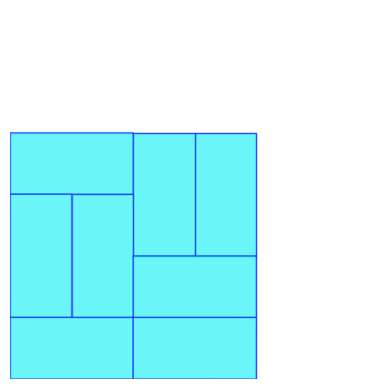

Относительное лучшение 0.9976999287019652


In [9]:
# Визуализация
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in improved_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()
print ("Относительное лучшение", (func(best_solution)-func(improved_solution))/func(best_solution))
